## SVM using Amazon Fine food reviews

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [34]:
# using SQLite Table to read data.
con = sqlite3.connect('/content/drive/My Drive/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 130000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (130000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [36]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [37]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [38]:
display['COUNT(*)'].sum()

393063

#  Exploratory Data Analysis

## Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [39]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [41]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(111488, 10)

In [42]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

85.76

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [43]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [45]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(111486, 10)


1    93593
0    17893
Name: Score, dtype: int64

#  Preprocessing

In [46]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
The tree came with no problems. It was packed well, no issues with the packaging or anything, it was all perfectly intact. It is very healthy, with a ton of buds and has no problems whatsoever. Fancy fancy little tree.
First of all, I would like to comment regarding previous reviews. I do not think the first review in 2005 was done by an employee, and that's not really a fair statement but rather an assumption lacking any real fact or evidence. It seems like a very small company that just enjoys making cheese straws and wants to share them with others. I sincerely doubt that, at the great price they are, the company even makes a ton of profit - which is a shame.<br /><br />Secondly, after tasting Aunt Lizzie's cheese straws for the first time this Fall, I will not eat anyone else's. I literally threw away a package of a VERY POPULAR chee

In [47]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


In [48]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
The tree came with no problems. It was packed well, no issues with the packaging or anything, it was all perfectly intact. It is very healthy, with a ton of buds and has no problems whatsoever. Fancy fancy little tree.
First of all, I would like to comment regarding previous reviews. I do not think the first review in 2005 was done by an employee, and that's not really a fair statement but rather an assumption lacking any real fact or evidence. It seems like a very small company that just enjoys making cheese straws and wants to share them with others. I sincerely doubt that, at the great price they are, the company even makes a ton of profit - which is a shame.Secondly, after tasting Aunt Lizzie's cheese straws for the first time this Fall, I will not eat anyone else's. I literally threw away a package of a VERY POPULAR cheese straw com

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [50]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

First of all, I would like to comment regarding previous reviews. I do not think the first review in 2005 was done by an employee, and that is not really a fair statement but rather an assumption lacking any real fact or evidence. It seems like a very small company that just enjoys making cheese straws and wants to share them with others. I sincerely doubt that, at the great price they are, the company even makes a ton of profit - which is a shame.<br /><br />Secondly, after tasting Aunt Lizzie is cheese straws for the first time this Fall, I will not eat anyone else is. I literally threw away a package of a VERY POPULAR cheese straw company that I received yesterday as a gift because when I tasted them, they just tasted bland and floury. I could not even bring myself to finish them. I crave Aunt Lizzie is cheese straws so much. (I recommend trying them with some Shiraz or other wine!)<br /><br />Our company gave out Aunt Lizzie is cheese straws as a corporate customer gift this year, 

In [51]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


In [52]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

First of all I would like to comment regarding previous reviews I do not think the first review in 2005 was done by an employee and that is not really a fair statement but rather an assumption lacking any real fact or evidence It seems like a very small company that just enjoys making cheese straws and wants to share them with others I sincerely doubt that at the great price they are the company even makes a ton of profit which is a shame br br Secondly after tasting Aunt Lizzie is cheese straws for the first time this Fall I will not eat anyone else is I literally threw away a package of a VERY POPULAR cheese straw company that I received yesterday as a gift because when I tasted them they just tasted bland and floury I could not even bring myself to finish them I crave Aunt Lizzie is cheese straws so much I recommend trying them with some Shiraz or other wine br br Our company gave out Aunt Lizzie is cheese straws as a corporate customer gift this year and I bet that Aunt Lizzie will

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [54]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 111486/111486 [01:27<00:00, 1274.07it/s]


In [55]:
final['CleanedText']=preprocessed_reviews
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dogs love saw pet store tag attached regarding...
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dogs loves chicken product china wont buying a...
70685,76879,B00002N8SM,A2579IQYG8Y9YF,Cynthia,0,0,1,1244332800,Works Great!,"Having used traditional fly rolls in the past,...",used traditional fly rolls past dubious hubby ...
70686,76880,B00002N8SM,A1S64UB4EOYFTK,Heather Paradee,0,0,1,1231027200,Prettier than fly paper,Well I received the item and placed it in the ...,well received item placed area put fly paper f...
70666,76859,B00002N8SM,A88YOFJG6IPOZ,duane,0,0,0,1343433600,RIpoff,What a horrible product. First of all the item...,horrible product first item not work week lots...


In [56]:
data=final.sample(100000)
print("For 100000 samples :\n" , data['Score'].value_counts())

For 100000 samples :
 1    83910
0    16090
Name: Score, dtype: int64


In [57]:
data1=final.sample(20000)
print("For 20000 samples :\n" , data1['Score'].value_counts())

For 20000 samples :
 1    16762
0     3238
Name: Score, dtype: int64


In [58]:
#Sorting According to Time
data["Time"] = pd.to_datetime(data["Time"], unit = "s")
data = data.sort_values(by = "Time")
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,1,2000-01-24,A sure death for flies,I bought a few of these after my apartment was...,bought apartment infested fruit flies hours tr...
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,2000-06-23,Great Product,This was a really good idea and the final prod...,really good idea final product outstanding use...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,2000-06-29,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,received shipment could hardly wait try produc...
121041,131217,B00004RAMX,A5NQLNC6QPGSI,Kim Nason,7,8,1,2000-07-31,End your Gopher Problems,I have just recently purchased the Woodstream ...,recently purchased woodstream corp gopher trap...
28087,30630,B00008RCMI,A284C7M23F0APC,A. Mendoza,0,0,1,2003-10-25,Best sugarless gum ever!,I love this stuff. It is sugar-free so it does...,love stuff sugar free not rot gums tastes good...


In [59]:
#Sorting According to Time
data1["Time"] = pd.to_datetime(data1["Time"], unit = "s")
data1 = data1.sort_values(by = "Time",axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
data1.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
10992,11991,B0000T15M8,A2928LJN5IISB4,chatchi,5,5,1,2003-11-05,The fruits of my labor,When chatchi's favorite afternoon treat became...,chatchi favorite afternoon treat became myster...
28085,30628,B00008RCMI,A3AKWA5CWSKOOH,"Ilaxi S. Patel ""Editor, kidsfreesouls.com & A...",0,0,1,2003-11-06,Refreshing Mouth Freshner!,A tennis player hubby of mine got this pack on...,tennis player hubby mine got pack rack opel co...
124630,135144,B001KWK1N8,A3FS8HDE2BTD5Z,"C. Boeck ""cebii""",1,1,1,2003-11-12,really the best,I buy this at our neighborhood supermarket. I...,buy neighborhood supermarket really best soymi...
86598,94281,B0000CNU2Q,A1NOWEOLKMRRXM,"T. Reinhardt ""olivia lee""",27,27,1,2003-12-18,The best bread crumbs...you'll never go back,Panko bread crumbs are just awesome. When use...,panko bread crumbs awesome used breading make ...
67336,73194,B0001217BS,AZ43813PGPQJ9,Brian Leone,4,7,1,2004-02-26,Nutella is amazing.,I just want to say that I'm eating Nutella rig...,want say eating nutella right nothing short am...


In [0]:
# this is for 100k points
X=data['CleanedText']
y=data['Score']
# this is for 20k points
X1=data1['CleanedText']
y1=data1['Score']

In [61]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33) # this is random splitting
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33) # random splitting
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)
print('*'*100)
# splitting for RBF-Kernal
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.33) # this is random splitting
X1_train, X1_cv, y1_train, y1_cv = train_test_split(X1_train, y1_train, test_size=0.33) # random splitting
print(X1_train.shape, y1_train.shape)
print(X1_cv.shape, y1_cv.shape)
print(X1_test.shape, y1_test.shape)

(44890,) (44890,)
(22110,) (22110,)
(33000,) (33000,)
****************************************************************************************************
(8978,) (8978,)
(4422,) (4422,)
(6600,) (6600,)


In [62]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn import svm, datasets
from scipy.stats import uniform
from collections import Counter
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
# Importing libraries
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix,precision_score,recall_score
from sklearn.metrics import roc_auc_score

print('**'*60)

************************************************************************************************************************


# Linear kernel 

## BAG OF WORDS

In [63]:
#BoW
bow = CountVectorizer().fit(X_train)
X_train_bow=bow.transform(X_train)
X_test_bow=bow.transform(X_test)
X_cv_bow=bow.transform(X_cv)
print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)

After vectorizations
(44890, 40452) (44890,)
(22110, 40452) (22110,)
(33000, 40452) (33000,)


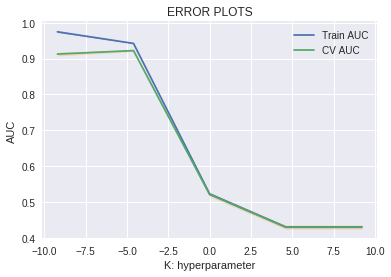

In [64]:

K = [10**-4,10**-2,10**0,10**2,10**4]

param_grid = {'alpha': K}
model = GridSearchCV(SGDClassifier(loss='hinge'), param_grid, cv=3 ,scoring = 'roc_auc')
model.fit(X_train_bow, y_train)
train_auc= model.cv_results_['mean_train_score']
train_auc_std= model.cv_results_['std_train_score']
cv_auc = model.cv_results_['mean_test_score'] 
cv_auc_std= model.cv_results_['std_test_score']

plt.plot(np.log(K), train_auc, label='Train AUC')

# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(K),train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(np.log(K), cv_auc, label='CV AUC')

# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(K),cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [65]:
optimal_alpha = model.best_estimator_.alpha
print("The optimal value of alpha(1/C) is : ",optimal_alpha)

The optimal value of alpha(1/C) is :  0.01


In [0]:
# Optimal value of alpha i.e.(1/C)
from sklearn.calibration import CalibratedClassifierCV
sgd = SGDClassifier(alpha=optimal_alpha,loss='hinge')
sgd_bow=CalibratedClassifierCV(base_estimator=sgd)
sgd_bow.fit(X_train_bow,y_train)
predictions_bow_test = sgd_bow.predict(X_test_bow)
predictions_bow_train = sgd_bow.predict(X_train_bow)
auc_bow_test=roc_auc_score(y_test, predictions_bow_test)
auc_bow_train=roc_auc_score(y_train, predictions_bow_train)

In [67]:
print('\nThe AUC socre test for value= %f is %f%%' % (optimal_alpha, auc_bow_test))
print('\nThe AUC socre train for value= %f is %f%%' % (optimal_alpha, auc_bow_train))
print('\nThe Error socre test for value= %f is %f%%' % (optimal_alpha, (1-auc_bow_test)))
print('\nThe Error socre train for value= %f is %f%%' % (optimal_alpha, (1-auc_bow_train)))


The AUC socre test for value= 0.010000 is 0.773407%

The AUC socre train for value= 0.010000 is 0.793610%

The Error socre test for value= 0.010000 is 0.226593%

The Error socre train for value= 0.010000 is 0.206390%


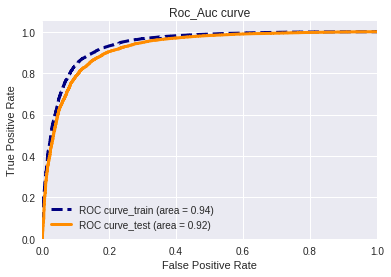

Train confusion matrix
[[ 4443  2869]
 [  767 36811]]
Test confusion matrix
[[ 3001  2237]
 [  725 27037]]


In [68]:
from sklearn.metrics import roc_curve, auc


### Computing ROC curve 
from sklearn import metrics
y_test_predict  =  sgd_bow.predict_proba(X_test_bow)[:,1]
y_train_predict =  sgd_bow.predict_proba(X_train_bow)[:,1]
train_fpr,train_tpr,_ =  metrics.roc_curve(y_train,y_train_predict) 
test_fpr,test_tpr, _ = metrics.roc_curve(y_test,y_test_predict)

roc_auc_test = auc(test_fpr, test_tpr) 
roc_auc_train = auc(train_fpr,train_tpr) 
### Plot
plt.figure()
lw = 3 
#plt.plot(train_fpr, train_tpr, color='navy',lw=lw, linestyle='--', label='ROC curve_train (area = %0.2f)' % roc_auc_train)
plt.plot(train_fpr,train_tpr, color='navy',
         lw=lw, linestyle='--', label='ROC curve_train (area = %0.2f)' % roc_auc_train)

plt.plot(test_fpr,test_tpr, color='darkorange', lw=lw,label='ROC curve_test (area = %0.2f)' % roc_auc_test)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc_Auc curve')
plt.legend()
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
linear_bow_train=confusion_matrix(y_train, sgd_bow.predict(X_train_bow))
print(linear_bow_train)
print("Test confusion matrix")
linear_bow_test=confusion_matrix(y_test, sgd_bow.predict(X_test_bow))
print(linear_bow_test)

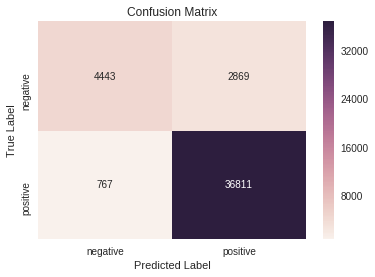

************************************************************************************************************************


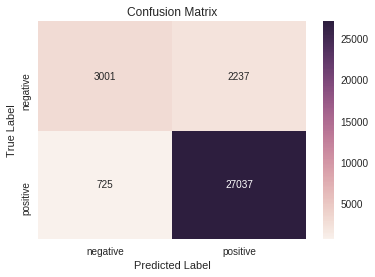

In [69]:
import seaborn as sns
class_label = ["negative", "positive"]
linear_train_heatmap = pd.DataFrame(linear_bow_train, index = class_label, columns = class_label)
sns.heatmap(linear_train_heatmap, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('**'*60)

linear_test_heatmap = pd.DataFrame(linear_bow_test, index = class_label, columns = class_label)
sns.heatmap(linear_test_heatmap, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [70]:
features_linear_bow=np.asarray(bow.get_feature_names())
sgd.fit(X_train_bow,y_train)
features_linear_bow.shape

(40452,)

In [71]:
w_linear_bow=sgd.coef_
weights=np.transpose(w_linear_bow)
features_frame_linearbow=pd.DataFrame(data=weights,index=features_linear_bow,columns=['weights'])
features_frame_linear_bow=features_frame_linearbow.sort_values(by=['weights'])
features_linearbow_pos=(features_frame_linear_bow.loc[features_frame_linear_bow['weights'] > 0]) # Pos Features
features_linearbow_neg=(features_frame_linear_bow.loc[features_frame_linear_bow['weights']<0]) #neg Features
print(features_linearbow_pos[0:10])
print(features_linearbow_neg[0:10])

                  weights
subcription  6.058093e-20
detected     6.058093e-20
fifties      1.211619e-19
wagyu        1.817428e-19
looser       1.817428e-19
exceeding    2.423237e-19
upsetting    2.423237e-19
digital      2.423237e-19
flovors      2.423237e-19
killer       2.423237e-19
                weights
disappointed  -0.477547
awful         -0.389789
money         -0.360387
worst         -0.348360
waste         -0.341232
terrible      -0.326977
horrible      -0.317177
bad           -0.298912
return        -0.292230
disappointing -0.281984


In [0]:
#############################################################################################################################################################

## TF-IDF

In [73]:
tfidf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10).fit(X_train)
X_train_tfidf=tfidf_vect.transform(X_train)
X_test_tfidf=tfidf_vect.transform(X_test)
X_cv_tfidf=tfidf_vect.transform(X_cv)
print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape)

After vectorizations
(44890, 26893) (44890,)
(22110, 26893) (22110,)
(33000, 26893) (33000,)


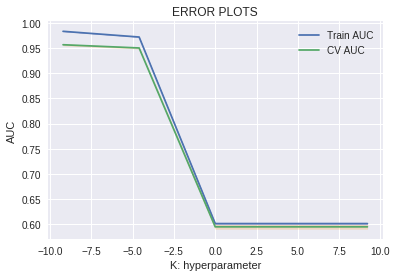

In [75]:
#K = [10**-4,10**-2,10**0,10**2,10**4]

#param_grid = {'alpha': K}
model_tfidf = GridSearchCV(SGDClassifier(loss='hinge'), param_grid, cv=3 ,scoring = 'roc_auc')
model_tfidf.fit(X_train_tfidf, y_train)
train_auc_tfidf= model_tfidf.cv_results_['mean_train_score']
train_auc_tfidf_std= model_tfidf.cv_results_['std_train_score']
cv_auc_tfidf = model_tfidf.cv_results_['mean_test_score'] 
cv_auc_tfidf_std= model_tfidf.cv_results_['std_test_score']

plt.plot(np.log(K), train_auc_tfidf, label='Train AUC')

# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(K),train_auc_tfidf - train_auc_tfidf_std,train_auc_tfidf + train_auc_tfidf_std,alpha=0.2,color='darkblue')

plt.plot(np.log(K), cv_auc_tfidf, label='CV AUC')

# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(K),cv_auc_tfidf - cv_auc_tfidf_std,cv_auc_tfidf + cv_auc_tfidf_std,alpha=0.2,color='darkorange')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [76]:
optimal_alpha_tfidf = model_tfidf.best_estimator_.alpha
print("The optimal value of alpha(1/C) is : ",optimal_alpha_tfidf)

The optimal value of alpha(1/C) is :  0.0001


In [77]:
sgd_tf = SGDClassifier(alpha=optimal_alpha_tfidf,loss='hinge')
sgd_tfidf=CalibratedClassifierCV(base_estimator=sgd_tf)
sgd_tfidf.fit(X_train_tfidf,y_train)
predictions_tfidf_test = sgd_tfidf.predict(X_test_tfidf)
predictions_tfidf_train = sgd_tfidf.predict(X_train_tfidf)
auc_tfidf_test=roc_auc_score(y_test, predictions_tfidf_test)
auc_tfidf_train=roc_auc_score(y_train, predictions_tfidf_train)
print('\nThe AUC socre test for value= %f is %f%%' % (optimal_alpha_tfidf, auc_tfidf_test))
print('\nThe AUC socre train for value= %f is %f%%' % (optimal_alpha_tfidf, auc_tfidf_train))
print('\nThe Error socre test for value= %f is %f%%' % (optimal_alpha_tfidf, (1-auc_tfidf_test)))
print('\nThe Error socre train for value= %f is %f%%' % (optimal_alpha_tfidf, (1-auc_tfidf_train)))


The AUC socre test for value= 0.000100 is 0.832626%

The AUC socre train for value= 0.000100 is 0.878444%

The Error socre test for value= 0.000100 is 0.167374%

The Error socre train for value= 0.000100 is 0.121556%


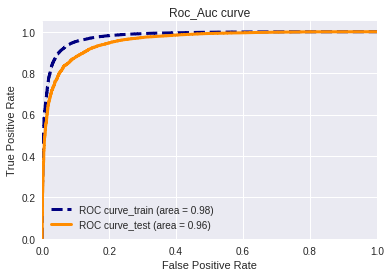

Train confusion matrix
[[ 5648  1664]
 [  584 36994]]
Test confusion matrix
[[ 3621  1617]
 [  723 27039]]


In [78]:
### Computing ROC curve 
#from sklearn import metrics
y_test_predict_tfidf  =  sgd_tfidf.predict_proba(X_test_tfidf)[:,1]
y_train_predict_tfidf =  sgd_tfidf.predict_proba(X_train_tfidf)[:,1]
train_tfidf_fpr,train_tfidf_tpr,_ =  metrics.roc_curve(y_train,y_train_predict_tfidf) 
test_tfidf_fpr,test_tfidf_tpr, _ = metrics.roc_curve(y_test,y_test_predict_tfidf)

roc_auc_test_tfidf = auc(test_tfidf_fpr, test_tfidf_tpr) 
roc_auc_train_tfidf = auc(train_tfidf_fpr,train_tfidf_tpr) 
### Plot
plt.figure()
#lw = 3 
#plt.plot(train_fpr, train_tpr, color='navy',lw=lw, linestyle='--', label='ROC curve_train (area = %0.2f)' % roc_auc_train)
plt.plot(train_tfidf_fpr,train_tfidf_tpr, color='navy',
         lw=lw, linestyle='--', label='ROC curve_train (area = %0.2f)' % roc_auc_train_tfidf)

plt.plot(test_tfidf_fpr,test_tfidf_tpr, color='darkorange', lw=lw,label='ROC curve_test (area = %0.2f)' % roc_auc_test_tfidf)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc_Auc curve')
plt.legend()
plt.show()

print("="*100)

#from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
linear_tfidf_train=confusion_matrix(y_train, sgd_tfidf.predict(X_train_tfidf))
print(linear_tfidf_train)
print("Test confusion matrix")
linear_tfidf_test=confusion_matrix(y_test, sgd_tfidf.predict(X_test_tfidf))
print(linear_tfidf_test)

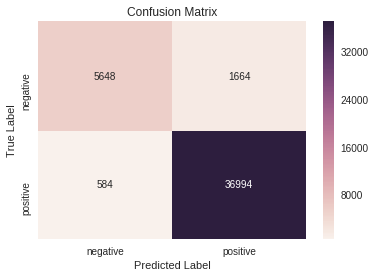

************************************************************************************************************************


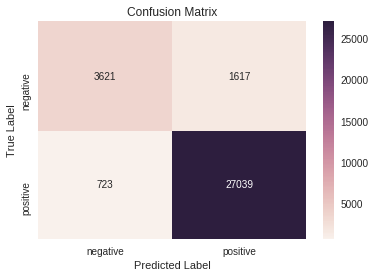

In [79]:
#import seaborn as sns
#class_label = ["negative", "positive"]
linear_train_tfidf_heatmap = pd.DataFrame(linear_tfidf_train, index = class_label, columns = class_label)
sns.heatmap(linear_train_tfidf_heatmap, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('**'*60)

linear_test_tfidf_heatmap = pd.DataFrame(linear_tfidf_test, index = class_label, columns = class_label)
sns.heatmap(linear_test_tfidf_heatmap, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [80]:
features_linear_tfidf=np.asarray(tfidf_vect.get_feature_names())
sgd_tf.fit(X_train_tfidf,y_train)
features_linear_tfidf.shape
w_linear_tfidf=sgd_tf.coef_
weights_tfidf=np.transpose(w_linear_tfidf)
features_frame_lineartfidf=pd.DataFrame(data=weights_tfidf,index=features_linear_tfidf,columns=['weights'])
features_frame_linear_tfidf=features_frame_lineartfidf.sort_values(by=['weights'])
features_lineartfidf_pos=(features_frame_linear_tfidf.loc[features_frame_linear_tfidf['weights'] > 0]) # Pos Features
features_lineartfidf_neg=(features_frame_linear_tfidf.loc[features_frame_linear_tfidf['weights'] < 0]) 
print(features_lineartfidf_pos[0:10])
print(features_lineartfidf_neg[0:10])
print('#'*60)

                    weights
know first     1.930521e-07
well add       1.682528e-05
not happen     1.794419e-05
healthy would  2.759582e-05
still sweet    3.293142e-05
bread good     3.433788e-05
quite frankly  6.782758e-05
try dog        7.071030e-05
fresh like     7.764144e-05
aloe vera      1.052469e-04
                weights
disappointed  -4.249723
worst         -3.449438
awful         -3.349544
disappointing -3.208838
not           -3.053056
not buy       -3.051626
not recommend -2.989407
horrible      -2.945788
terrible      -2.894470
not good      -2.765629
############################################################


## Word2Vec

In [0]:
#W2V

import re
import string
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special character
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return cleaned 
# Removing the Punctuations and HTML Tags tool

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [0]:
import gensim
i=0
sent_of_train=[]
for sentance in X_train:
    sent_of_train.append(sentance.split())
w2v_model=gensim.models.Word2Vec(sent_of_train,min_count=5,size=200, workers=4)    
print("Type of w2v_model",type(w2v_model))
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

Type of w2v_model <class 'gensim.models.word2vec.Word2Vec'>
number of words that occured minimum 5 times  12882
sample words  ['tangy', 'tomato', 'based', 'sauce', 'containing', 'lemon', 'cilantro', 'flavors', 'good', 'chicken', 'pork', 'serve', 'basmati', 'rice', 'quick', 'yummy', 'using', 'thai', 'kitchen', 'roasted', 'red', 'chili', 'paste', 'years', 'flavorful', 'without', 'hot', 'make', 'green', 'unroasted', 'never', 'liked', 'found', 'much', 'unfortunately', 'local', 'health', 'food', 'store', 'carries', 'ones', 'not', 'like', 'ordered', 'case', 'amazon', 'one', 'jar', 'leaking', 'oil']


In [0]:
# List of sentence in X_test text
sent_of_test=[]
for sent1 in X_test:
    sent_of_test.append(sent1.split())   
#List of sentences in X_cv
sent_of_cv=[]
for sent2 in X_cv:
    sent_of_cv.append(sent2.split())

##  Avg W2V, TFIDF-W2V

### Avg W2v

In [0]:
# compute average word2vec for each review for X_train .
train_vectors = []; 
for senti in sent_of_train:
    sent_vec_train = np.zeros(200) 
    cnt_words_train =0; 
    for wordi in senti: # 
        if wordi in w2v_words:
            vec_train = w2v_model.wv[wordi]
            sent_vec_train += vec_train
            cnt_words_train += 1
    if cnt_words_train != 0:
        sent_vec_train /= cnt_words_train
    train_vectors.append(sent_vec_train)
    
# compute average word2vec for each review for X_test .
test_vectors = []; 
for sentj in sent_of_test:
    sent_vec_test = np.zeros(200) 
    cnt_words_test =0; 
    for wordj in sentj: # 
        if wordj in w2v_words:
            vec_test = w2v_model.wv[wordj]
            sent_vec_test += vec_test
            cnt_words_test += 1
    if cnt_words_test != 0:
        sent_vec_test /= cnt_words_test
    test_vectors.append(sent_vec_test) 
    
# compute average word2vec for each review for X_cv .
cv_vectors = []; 
for sentk in sent_of_cv:
    sent_vec_cv = np.zeros(200) 
    cnt_words_cv =0; 
    for wordk in sentk: # 
        if wordk in w2v_words:
            vec_cv = w2v_model.wv[wordk]
            sent_vec_cv += vec_cv
            cnt_words_cv += 1
    if cnt_words_cv != 0:
        sent_vec_cv /= cnt_words_cv
    cv_vectors.append(sent_vec_cv)
    

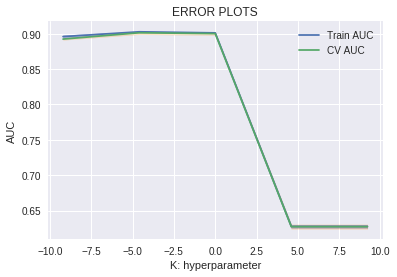

In [0]:
#K = [10**-4,10**-2,10**0,10**2,10**4]

#param_grid = {'alpha': K}
model_avg = GridSearchCV(SGDClassifier(loss='hinge'), param_grid, cv=3 ,scoring = 'roc_auc')
model_avg.fit(train_vectors, y_train)
train_auc_avg= model_avg.cv_results_['mean_train_score']
train_auc_avg_std= model_avg.cv_results_['std_train_score']
cv_auc_avg = model_avg.cv_results_['mean_cv_score'] 
cv_auc_avg_std= model_avg.cv_results_['std_cv_score']

plt.plot(np.log(K), train_auc_avg, label='Train AUC')

# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(K),train_auc_avg - train_auc_avg_std,train_auc_avg + train_auc_avg_std,alpha=0.2,color='darkblue')

plt.plot(np.log(K), cv_auc_avg, label='CV AUC')

# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(K),cv_auc_avg - cv_auc_avg_std,cv_auc_avg + cv_auc_avg_std,alpha=0.2,color='darkorange')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
optimal_alpha_avg = model_avg.best_estimator_.alpha
print("The optimal value of alpha(1/C) is : ",optimal_alpha_avg)

The optimal value of alpha(1/C) is :  0.01


In [0]:
sgd_avg = SGDClassifier(alpha=optimal_alpha_avg,loss='hinge')
sgd_avg=CalibratedClassifierCV(base_estimator=sgd_avg)
sgd_avg.fit(train_vectors,y_train)
predictions_avg_test = sgd_avg.predict(test_vectors)
predictions_avg_train = sgd_avg.predict(train_vectors)
auc_avg_test=roc_auc_score(y_test, predictions_avg_test)
auc_avg_train=roc_auc_score(y_train, predictions_avg_train)
print('\nThe AUC socre test for value= %f is %f%%' % (optimal_alpha_avg, auc_avg_test))
print('\nThe AUC socre train for value= %f is %f%%' % (optimal_alpha_avg, auc_avg_train))
print('\nThe Error socre test for value= %f is %f%%' % (optimal_alpha_avg, (1-auc_avg_test)))
print('\nThe Error socre train for value= %f is %f%%' % (optimal_alpha_avg, (1-auc_avg_train)))


The AUC socre test for value= 0.010000 is 0.701730%

The AUC socre train for value= 0.010000 is 0.717761%

The Error socre test for value= 0.010000 is 0.298270%

The Error socre train for value= 0.010000 is 0.282239%


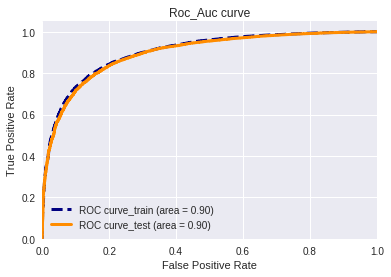

Train confusion matrix
[[ 3374  3808]
 [ 1292 36416]]
Test confusion matrix
[[ 2313  2968]
 [  957 26762]]


In [0]:
### Computing ROC curve 
#from sklearn import metrics
y_test_predict_avg  =  sgd_avg.predict_proba(test_vectors)[:,1]
y_train_predict_avg =  sgd_avg.predict_proba(train_vectors)[:,1]
train_avg_fpr,train_avg_tpr,_ =  metrics.roc_curve(y_train,y_train_predict_avg) 
test_avg_fpr,test_avg_tpr, _ = metrics.roc_curve(y_test,y_test_predict_avg)

roc_auc_test_avg = auc(test_avg_fpr, test_avg_tpr) 
roc_auc_train_avg = auc(train_avg_fpr,train_avg_tpr) 
### Plot
plt.figure()
#lw = 3 
#plt.plot(train_fpr, train_tpr, color='navy',lw=lw, linestyle='--', label='ROC curve_train (area = %0.2f)' % roc_auc_train)
plt.plot(train_avg_fpr,train_avg_tpr, color='navy',
         lw=lw, linestyle='--', label='ROC curve_train (area = %0.2f)' % roc_auc_train_avg)

plt.plot(test_avg_fpr,test_avg_tpr, color='darkorange', lw=lw,label='ROC curve_test (area = %0.2f)' % roc_auc_test_avg)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc_Auc curve')
plt.legend()
plt.show()

print("="*100)

#from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
linear_avg_train=confusion_matrix(y_train, sgd_avg.predict(train_vectors))
print(linear_avg_train)
print("Test confusion matrix")
linear_avg_test=confusion_matrix(y_test, sgd_avg.predict(test_vectors))
print(linear_avg_test)

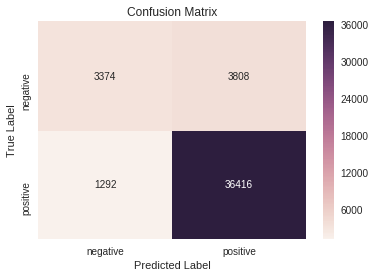

************************************************************************************************************************


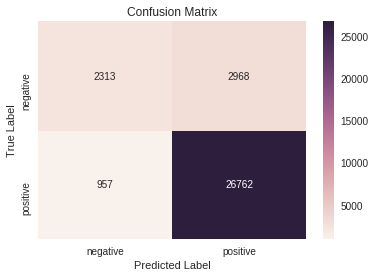

In [0]:
#import seaborn as sns
#class_label = ["negative", "positive"]
linear_train_avg_heatmap = pd.DataFrame(linear_avg_train, index = class_label, columns = class_label)
sns.heatmap(linear_train_avg_heatmap, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('**'*60)

linear_test_avg_heatmap = pd.DataFrame(linear_avg_test, index = class_label, columns = class_label)
sns.heatmap(linear_test_avg_heatmap, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### TFIDF weighted W2v

In [0]:
# TF-IDF weighted Word2Vec
tfidf_vectorizer = TfidfVectorizer()

# final_tf_idf1 is the sparse matrix with row= sentence, col=word and cell_val = tfidf
final_tfidf_train = tfidf_vectorizer.fit_transform(X_train)
final_tfidf_test = tfidf_vectorizer.transform(X_test)
final_tfidf_cv = tfidf_vectorizer.transform(X_cv)
dictionary = dict(zip(tfidf_vectorizer.get_feature_names(), list(tfidf_vectorizer.idf_)))

# tfidf words/col-names
tfidf_featuress = tfidf_vectorizer.get_feature_names()

# compute TFIDF Weighted Word2Vec for each review for X_train .
tfidf_train_vectors = []; 
row=0;
for senttrain in sent_of_train: 
    sent_vec_trains = np.zeros(200) 
    weight_sum_trains =0; 
    for word_trains in senttrain: 
        if word_trains in w2v_words and word_trains in tfidf_featuress:
            vec_1 = w2v_model.wv[word_trains]
            # obtain the tf_idfidf of a word in a sentence/review
            #tfidf_train = final_tfidf_train[row, tfidf_features.index(word_train)]
            tfidf_train = dictionary[word_trains]*(senttrain.count(word_trains)/len(senttrain))
            sent_vec_trains += (vec_1 * tfidf_train)
            weight_sum_trains += tfidf_train
    if weight_sum_trains != 0:
        sent_vec_trains /= weight_sum_trains
    tfidf_train_vectors.append(sent_vec_trains)
    row += 1

In [0]:
# compute TFIDF Weighted Word2Vec for each review for X_cv .
tfidf_cv_vectors = []; 
#row=0;
for sentcv in tqdm(sent_of_cv): 
    sent_vec_cvs = np.zeros(200) 
    weight_sum_cvs =0; 
    for word_cv in sentcv: 
        if word_cv in w2v_words and word_cv in tfidf_featuress:
            vec_2 = w2v_model.wv[word_cv]
            # obtain the tf_idfidf of a word in a sentence/review
            #tfidf_cv = final_tfidf_cv[row, tfidf_features.index(word)]
            tfidf_cv = dictionary[word_cv]*(sentcv.count(word_cv)/len(sentcv))
            sent_vec_cvs += (vec_2 * tfidf_cv)
            weight_sum_cvs += tfidf_cv
    if weight_sum_cvs != 0:
        sent_vec_cvs /= weight_sum_cvs
    tfidf_cv_vectors.append(sent_vec_cvs)
    row += 1

100%|██████████| 22110/22110 [09:44<00:00, 37.84it/s]


In [0]:
# compute TFIDF Weighted Word2Vec for each review for X_test .
tfidf_test_vectors = []; 
#row=0;
for senttest in tqdm(sent_of_test): 
    sent_vec_tests = np.zeros(200) 
    weight_sum_tests =0; 
    for word_test in senttest: 
        if word_test in w2v_words and word_test in tfidf_featuress:
            vec_3 = w2v_model.wv[word_test]
            # obtain the tf_idfidf of a word in a sentence/review
            #tfidf_test = final_tfidf_test[row, tfidf_features.index(word)]
            tfidf_test = dictionary[word_test]*(senttest.count(word_test)/len(senttest))
            sent_vec_tests += (vec_3 * tfidf_test)
            weight_sum_tests += tfidf_test
    if weight_sum_tests != 0:
        sent_vec_tests /= weight_sum_tests
    tfidf_test_vectors.append(sent_vec_tests)
    row += 1

100%|██████████| 33000/33000 [15:31<00:00, 35.44it/s]


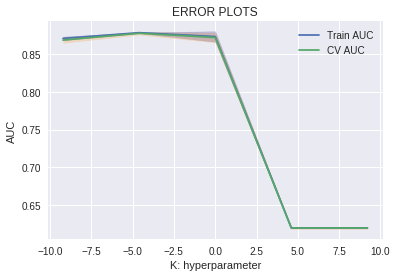

In [0]:
K = [10**-4,10**-2,10**0,10**2,10**4]

param_grid = {'alpha': K}
model_tfw2v = GridSearchCV(SGDClassifier(loss='hinge'), param_grid, cv=3 ,scoring = 'roc_auc')
model_tfw2v.fit(tfidf_train_vectors, y_train)
train_auc_tfw2v= model_tfw2v.cv_results_['mean_train_score']
train_auc_tfw2v_std= model_tfw2v.cv_results_['std_train_score']
cv_auc_tfw2v = model_tfw2v.cv_results_['mean_cv_score'] 
cv_auc_tfw2v_std= model_tfw2v.cv_results_['std_cv_score']

plt.plot(np.log(K), train_auc_tfw2v, label='Train AUC')

# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(K),train_auc_tfw2v - train_auc_tfw2v_std,train_auc_tfw2v + train_auc_tfw2v_std,alpha=0.2,color='darkblue')

plt.plot(np.log(K), cv_auc_tfw2v, label='CV AUC')

# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(K),cv_auc_tfw2v - cv_auc_tfw2v_std,cv_auc_tfw2v + cv_auc_tfw2v_std,alpha=0.2,color='darkorange')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
optimal_alpha_tfw2v = model_tfw2v.best_estimator_.alpha
print("The optimal value of alpha(1/C) is : ",optimal_alpha_tfw2v)

The optimal value of alpha(1/C) is :  0.01


In [0]:
sgd_w2v = SGDClassifier(alpha=optimal_alpha_tfw2v,loss='hinge')
sgd_tfw2v=CalibratedClassifierCV(base_estimator=sgd_w2v)
sgd_tfw2v.fit(tfidf_train_vectors,y_train)
predictions_tfw2v_test = sgd_tfw2v.predict(tfidf_test_vectors)
predictions_tfw2v_train = sgd_tfw2v.predict(tfidf_train_vectors)
auc_tfw2v_test=roc_auc_score(y_test, predictions_tfw2v_test)
auc_tfw2v_train=roc_auc_score(y_train, predictions_tfw2v_train)
print('\nThe AUC socre test for value= %f is %f%%' % (optimal_alpha_tfw2v, auc_tfw2v_test))
print('\nThe AUC socre train for value= %f is %f%%' % (optimal_alpha_tfw2v, auc_tfw2v_train))
print('\nThe Error socre test for value= %f is %f%%' % (optimal_alpha_tfw2v, (1-auc_tfw2v_test)))
print('\nThe Error socre train for value= %f is %f%%' % (optimal_alpha_tfw2v, (1-auc_tfw2v_train)))


The AUC socre test for value= 0.010000 is 0.667521%

The AUC socre train for value= 0.010000 is 0.674797%

The Error socre test for value= 0.010000 is 0.332479%

The Error socre train for value= 0.010000 is 0.325203%


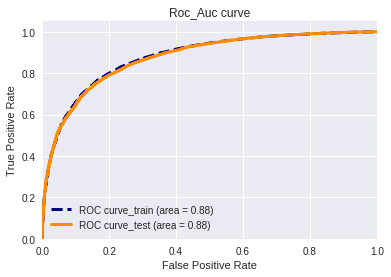

Train confusion matrix
[[ 2730  4450]
 [ 1155 36555]]
Test confusion matrix
[[ 1934  3390]
 [  781 26895]]


In [0]:
### Computing ROC curve 
from sklearn import metrics
y_test_predict_tfw2v  =  sgd_tfw2v.predict_proba(tfidf_test_vectors)[:,1]
y_train_predict_tfw2v =  sgd_tfw2v.predict_proba(tfidf_train_vectors)[:,1]
train_tfw2v_fpr,train_tfw2v_tpr,_ =  metrics.roc_curve(y_train,y_train_predict_tfw2v) 
test_tfw2v_fpr,test_tfw2v_tpr, _ = metrics.roc_curve(y_test,y_test_predict_tfw2v)

roc_auc_test_tfw2v = auc(test_tfw2v_fpr, test_tfw2v_tpr) 
roc_auc_train_tfw2v = auc(train_tfw2v_fpr,train_tfw2v_tpr) 
### Plot
plt.figure()
lw = 3 
#plt.plot(train_fpr, train_tpr, color='navy',lw=lw, linestyle='--', label='ROC curve_train (area = %0.2f)' % roc_auc_train)
plt.plot(train_tfw2v_fpr,train_tfw2v_tpr, color='navy',
         lw=lw, linestyle='--', label='ROC curve_train (area = %0.2f)' % roc_auc_train_tfw2v)

plt.plot(test_tfw2v_fpr,test_tfw2v_tpr, color='darkorange', lw=lw,label='ROC curve_test (area = %0.2f)' % roc_auc_test_tfw2v)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc_Auc curve')
plt.legend()
plt.show()

print("="*100)

#from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
linear_tfw2v_train=confusion_matrix(y_train, sgd_tfw2v.predict(tfidf_train_vectors))
print(linear_tfw2v_train)
print("Test confusion matrix")
linear_tfw2v_test=confusion_matrix(y_test, sgd_tfw2v.predict(tfidf_test_vectors))
print(linear_tfw2v_test)

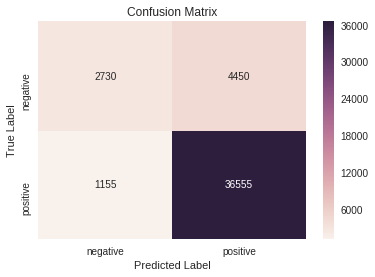

************************************************************************************************************************


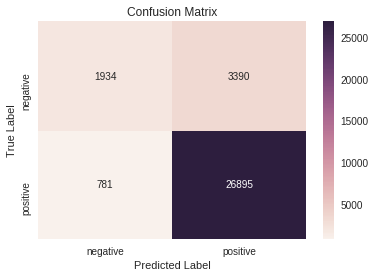

In [0]:
import seaborn as sns
class_label = ["negative", "positive"]
linear_train_tfw2v_heatmap = pd.DataFrame(linear_tfw2v_train, index = class_label, columns = class_label)
sns.heatmap(linear_train_tfw2v_heatmap, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('**'*60)

linear_test_tfw2v_heatmap = pd.DataFrame(linear_tfw2v_test, index = class_label, columns = class_label)
sns.heatmap(linear_test_tfw2v_heatmap, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Note :-    By Observing to all NLP models that i have applied,  the TFIDF has got the best results with SGDClassifier. So, According to given suggestions in class room, I am applying SVC on TFIDF


## RBF-Kernal

### Applying TFIDF

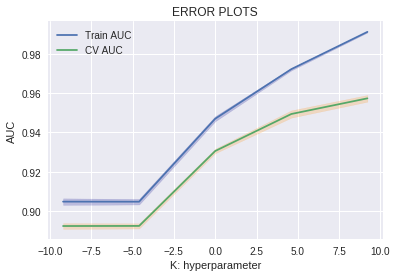

In [0]:
from sklearn.svm import SVC
K = [10**-4,10**-2,10**0,10**2,10**4]

param_grid = {'C': K}
model_tfidf = GridSearchCV(SVC(probability=True), param_grid, cv=3 ,scoring = 'roc_auc')
model_tfidf.fit(X_train_tfidf, y_train)
train_auc_tfidf= model_tfidf.cv_results_['mean_train_score']
train_auc_tfidf_std= model_tfidf.cv_results_['std_train_score']
cv_auc_tfidf = model_tfidf.cv_results_['mean_test_score'] 
cv_auc_tfidf_std= model_tfidf.cv_results_['std_test_score']

plt.plot(np.log(K), train_auc_tfidf, label='Train AUC')

# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(K),train_auc_tfidf - train_auc_tfidf_std,train_auc_tfidf + train_auc_tfidf_std,alpha=0.2,color='darkblue')

plt.plot(np.log(K), cv_auc_tfidf, label='CV AUC')

# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(K),cv_auc_tfidf - cv_auc_tfidf_std,cv_auc_tfidf + cv_auc_tfidf_std,alpha=0.2,color='darkorange')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
optimal_C = model_tfidf.best_estimator_.C
print("The optimal value of C is : ",optimal_C)

The optimal value of C is :  10000


In [0]:
# SVC with RBF kernel with Optimal value of C
svc = SVC(C=optimal_C,probability=True)
svc.fit(X_train_tfidf,y_train)
predictions_tfidf_test = svc.predict(X_test_tfidf)
predictions_tfidf_train = svc.predict(X_train_tfidf)
auc_tfidf_test=roc_auc_score(y_test, predictions_tfidf_test)
auc_tfidf_train=roc_auc_score(y_train, predictions_tfidf_train)
print('\nThe AUC socre test for value= %f is %f%%' % (optimal_C, auc_tfidf_test))
print('\nThe AUC socre train for value= %f is %f%%' % (optimal_C, auc_tfidf_train))
print('\nThe Error socre test for value= %f is %f%%' % (optimal_C, (1-auc_tfidf_test)))
print('\nThe Error socre train for value= %f is %f%%' % (optimal_C, (1-auc_tfidf_train)))



The AUC socre test for value= 10000.000000 is 0.823596%

The AUC socre train for value= 10000.000000 is 0.898723%

The Error socre test for value= 10000.000000 is 0.176404%

The Error socre train for value= 10000.000000 is 0.101277%


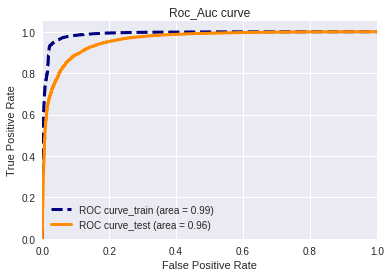

Train confusion matrix
[[ 5725  1396]
 [  246 37523]]
Test confusion matrix
[[ 3495  1755]
 [  514 27236]]


In [0]:
### Computing ROC curve 
from sklearn import metrics
y_test_predict_tfidf  =  svc.predict_proba(X_test_tfidf)[:,1]
y_train_predict_tfidf =  svc.predict_proba(X_train_tfidf)[:,1]
train_tfidf_fpr,train_tfidf_tpr,_ =  metrics.roc_curve(y_train,y_train_predict_tfidf) 
test_tfidf_fpr,test_tfidf_tpr, _ = metrics.roc_curve(y_test,y_test_predict_tfidf)

roc_auc_test_tfidf = auc(test_tfidf_fpr, test_tfidf_tpr) 
roc_auc_train_tfidf = auc(train_tfidf_fpr,train_tfidf_tpr) 
### Plot
plt.figure()
lw = 3 
#plt.plot(train_fpr, train_tpr, color='navy',lw=lw, linestyle='--', label='ROC curve_train (area = %0.2f)' % roc_auc_train)
plt.plot(train_tfidf_fpr,train_tfidf_tpr, color='navy',
         lw=lw, linestyle='--', label='ROC curve_train (area = %0.2f)' % roc_auc_train_tfidf)

plt.plot(test_tfidf_fpr,test_tfidf_tpr, color='darkorange', lw=lw,label='ROC curve_test (area = %0.2f)' % roc_auc_test_tfidf)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc_Auc curve')
plt.legend()
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
rbf_tfidf_train=confusion_matrix(y_train, svc.predict(X_train_tfidf))
print(rbf_tfidf_train)
print("Test confusion matrix")
rbf_tfidf_test=confusion_matrix(y_test, svc.predict(X_test_tfidf))
print(rbf_tfidf_test)

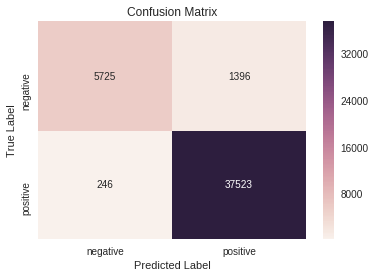

************************************************************************************************************************


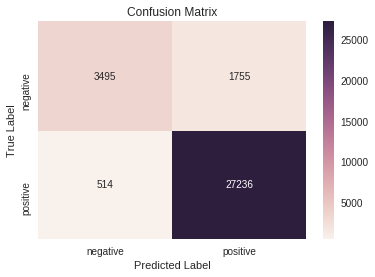

In [0]:
import seaborn as sns
class_label = ["negative", "positive"]
rbf_train_tfidf_heatmap = pd.DataFrame(rbf_tfidf_train, index = class_label, columns = class_label)
sns.heatmap(rbf_train_tfidf_heatmap, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('**'*60)

rbf_test_tfidf_heatmap = pd.DataFrame(rbf_tfidf_test, index = class_label, columns = class_label)
sns.heatmap(rbf_test_tfidf_heatmap, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Conclusions section